## Modelo de Machine Learning: Similitud del Coseno
Para desarrollar nuestro sistema de recomendaciones, utilizaremos las columnas *“developer”, “genre” y “specs”*, creando una nueva columna llamada *combined_features*.
En esta etapa, normalizaremos el texto eliminando palabras vacías (stop words) en inglés y símbolos innecesarios, dejando solo letras para un análisis más preciso.
### *Se basa en dos conceptos fundamentales*: ###
-**Frecuencia de Término (TF):** Mide cuántas veces aparece una palabra en un documento en relación con el total de palabras. Las palabras más frecuentes son consideradas más relevantes.
-**Frecuencia Inversa de Documento (IDF):** Evalúa la importancia de una palabra en todo el conjunto de documentos. Palabras comunes tienen un IDF bajo, mientras que palabras raras tienen un IDF alto.  Estos conceptos nos permitirán calcular similitudes y ofrecer recomendaciones personalizadas a los jugadores.

In [30]:
# 1. Importar las librerias necesarias y cargar el dataset 
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

games= pd.read_parquet(r"C:\Users\veram\OneDrive\Escritorio\proyecto octubre\Datos_parquet\data_games.parquet")
df_games = games


In [24]:
# 2. indagaremos en la distribución de géneros, desarrolladores y aspectos dentro del dataset 
print(df_games['genre'].value_counts())
print(df_games['developer'].value_counts())
print(df_games['specs'].isnull().sum())


genre
action                     10617
casual                      4248
adventure                   4109
indie                       3330
simulation                  1835
strategy                    1125
rpg                          650
racing                       447
design amp illustration      283
massively multiplayer        221
animation amp modeling       120
sports                        57
utilities                     40
audio production              38
platformer                    12
free play                     11
education                      6
early access                   4
video production               4
web publishing                 3
horror                         2
rpgmaker                       2
photo editing                  2
chess                          2
open world                     1
hidden object                  1
retro                          1
arcade                         1
funny                          1
zombies                        1
fema

In [31]:
# 3. Crearemos la Función para normalizar texto y la aplicaremos a nuestra data
def normalize_text(text):
    text = text.lower()  # Pasar a minúsculas
    text = re.sub(r'[^a-z\s]', '', text)  # Eliminar símbolos y signos
    return text

# 4. Crearemos una  nueva columna llamada 'combined_features'
df_games['combined_features'] = (
    df_games['developer'].apply(normalize_text) + ' ' +
    df_games['genre'].apply(normalize_text) + ' ' +
    df_games['specs'].apply(normalize_text)
)

print(df_games['combined'].head())


0          singleplayer kotoshiro action
1    singleplayer secret level srl indie
2       singleplayer poolians.com casual
3                   singleplayer  action
4    singleplayer trickjump games action
Name: combined, dtype: object


In [3]:
# 5.Inicializamos el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# 6. Aplicamos el vectorizador a la columna combinada
tfidf_matrix = vectorizer.fit_transform(df_games['combined'])


# 7.Calcular la matriz de similitud del coseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

'''
# 7.1 de ser necesario guardar el resultado:

-Guardar la matriz de similitud
joblib.dump(cosine_sim, 'cosine_sim.joblib')

-Guardar el vectorizador para usarlo más adelante
joblib.dump(vectorizer, 'vectorizer.joblib')


'''


### Función de Recomendaciones
Hemos desarrollado una función que genera recomendaciones basadas en los datos procesados anteriormente.
-**Transformación**: Convierte el título del videojuego a minúsculas y elimina espacios en blanco.
-**Búsqueda**: Localiza el índice del videojuego en el DataFrame df_games donde el título coincide.
-**Verificación**: Si se encuentra el índice, se devuelve; de lo contrario, se lanza una excepción.
Esta función permite acceder de manera eficiente a las recomendaciones más relevantes para los usuarios.

In [27]:
#8 . creamos la función: 

def get_index_from_title(game_title, df_games):
    
    game_title = game_title.lower().strip()
    
    # 8.1Buscamos el índice del juego cuyo título coincide con game_title
    indices = df_games[df_games['app_name'].str.lower() == game_title].index
    
    #8.2 Verificamos si hay coincidencias
    if not indices.empty:
        return indices[0]
    raise ValueError("Título no encontrado")


### Descripción del Proceso de Recomendación
-**Obtención de Índice**: Se invoca la función get_index_from_title para localizar el índice del videojuego solicitado.
-**Cálculo de Similitud**: Se calcula la similitud del coseno entre el videojuego elegido y los demás.
-**Ordenación**: Los videojuegos se ordenan según su puntuación de similitud.
-**Selección de Resultados**: Se extraen y devuelven los nombres de los 5 videojuegos más similares.

In [28]:
# 9. Función  de recomendación:

def get_recommendations(game_title, df_games):

    try:
        # 9.1 Obtenemos el índice del videojuego buscado por título
        idx = get_index_from_title(game_title, df_games)
        
        # 9.2Calculamos la similitud del coseno
        cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
        
        # 9.3Enumeramos los videojuegos y se ordenan por su similitud
        sim_scores = list(enumerate(cosine_sim[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # 9.4 Obtenemos los índices de los 5 videojuegos más similares
        game_indices = [i[0] for i in sim_scores[1:6]]
        
        # 9.5 Devolvemos los nombres de los videojuegos recomendados
        return df_games['app_name'].iloc[game_indices].tolist()
   
    except ValueError:
        return ["No se encontró el videojuego en los datos"]


### Ejemplo de Uso
Al utilizar la función get_recommendations, asegúrate de que el tfidf_matrix ya esté calculado. A continuación se presenta un ejemplo de cómo implementarlo:

In [33]:
# 10.Llamada a la función con el título deseado
resultados_recomendaciones = get_recommendations("Lew Pulsipher's Doomstar", df_games)
print("Recomendaciones:", resultados_recomendaciones)


Recomendaciones: ['Talent Not Included', 'Ludwig', 'Will Glow the Wisp', 'Maze Up!', 'Air Conflicts: Secret Wars']


### Gráfica

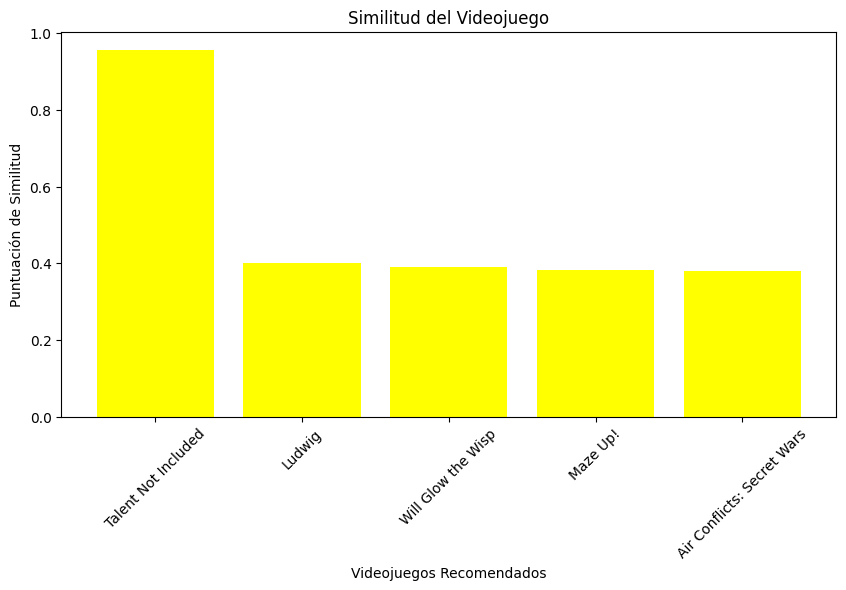

In [34]:
import matplotlib.pyplot as plt


# 11. Creamos una representacion gráfica de nuestra consulta:
game_title = "Lew Pulsipher's Doomstar"

# 11.1 Obtener recomendaciones
recomendaciones = get_recommendations(game_title, df_games)

# 11.2 Obtener la similitud para el gráfico
idx = get_index_from_title(game_title, df_games)
cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)
sim_scores = list(enumerate(cosine_sim[0]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
top_similarities = sim_scores[1:6]  # Top 5

# 11.3 Crear DataFrame para el gráfico
df_similarities = pd.DataFrame(top_similarities, columns=['Index', 'Similarity'])
df_similarities['Game'] = df_games['app_name'].iloc[df_similarities['Index']].values

# 11.4 Gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(df_similarities['Game'], df_similarities['Similarity'], color='yellow')
plt.title('Similitud del Videojuego')
plt.xlabel('Videojuegos Recomendados')
plt.ylabel('Puntuación de Similitud')
plt.xticks(rotation=45)
plt.show()
